In [ ]:
#@title Install dependencies
!pip install -q openai datasets matplotlib tqdm pandas

In [ ]:
#@title Imports and global configuration

import os
import math
import random
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datasets import load_dataset
from getpass import getpass
from openai import OpenAI

# Reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

# Model and training hyperparameters
MODEL_NAME = "gpt-4o"  # swap if you want a different model
TEMPERATURE = 0.0

TRAIN_BUDGET_TOKENS = 120_000      # token budget per policy for training
MAX_TRAIN_QUESTIONS_PER_POLICY = 400
HOLDOUT_QUESTIONS = 200            # shared validation questions per policy

# OpenAI API key
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")

client = OpenAI()

print("Config:")
print("  model:", MODEL_NAME)
print("  seed:", SEED)
print("  train budget tokens:", TRAIN_BUDGET_TOKENS)
print("  max train questions per policy:", MAX_TRAIN_QUESTIONS_PER_POLICY)
print("  holdout questions:", HOLDOUT_QUESTIONS)

Config:
  model: gpt-4o
  seed: 0
  train budget tokens: 120000
  max train questions per policy: 400
  holdout questions: 200


In [ ]:
#@title Load ARC-Challenge and normalize

arc = load_dataset("allenai/ai2_arc", "ARC-Challenge")

train_raw = arc["train"]
valid_raw = arc["validation"]

def normalize_arc_split(split_ds):
    examples = []
    for ex in split_ds:
        labels = list(ex["choices"]["label"])
        texts = list(ex["choices"]["text"])

        # Require exactly four options labeled A, B, C, D
        if set(labels) != {"A", "B", "C", "D"}:
            continue
        if len(labels) != 4:
            continue

        mapping = {lab: txt for lab, txt in zip(labels, texts)}
        ordered_texts = [mapping[c] for c in ["A", "B", "C", "D"]]

        answer = ex["answerKey"].strip()
        if answer not in ("A", "B", "C", "D"):
            continue

        examples.append(
            {
                "id": ex["id"],
                "question": ex["question"].strip(),
                "choices": {
                    "label": ["A", "B", "C", "D"],
                    "text": ordered_texts,
                },
                "answerKey": answer,
            }
        )
    return examples

train_examples = normalize_arc_split(train_raw)
valid_examples = normalize_arc_split(valid_raw)

print(f"Train examples: {len(train_examples)}")
print(f"Valid examples: {len(valid_examples)}")

# Fixed training subset order shared across all policies
rng_train = random.Random(SEED)
max_train_questions = min(MAX_TRAIN_QUESTIONS_PER_POLICY, len(train_examples))
train_indices = rng_train.sample(range(len(train_examples)), k=max_train_questions)
print(f"Max train questions per policy: {max_train_questions}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

ARC-Challenge/train-00000-of-00001.parqu(…):   0%|          | 0.00/190k [00:00<?, ?B/s]

ARC-Challenge/test-00000-of-00001.parque(…):   0%|          | 0.00/204k [00:00<?, ?B/s]

ARC-Challenge/validation-00000-of-00001.(…):   0%|          | 0.00/55.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1119 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1172 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/299 [00:00<?, ? examples/s]

Train examples: 1094
Valid examples: 291
Max train questions per policy: 400


In [ ]:
#@title Define prompt variants and ARC formatting

import re

LETTER_RE = re.compile(r"\b([ABCD])\b", re.IGNORECASE)

@dataclass
class PromptVariant:
    name: str
    system: str

BASE_USER_FOOTER = "Answer with only the single letter A, B, C, or D."

def format_arc_user(ex: Dict[str, Any]) -> str:
    labels = ex["choices"]["label"]
    texts = ex["choices"]["text"]
    lines = []
    lines.append("Question:")
    lines.append(ex["question"])
    lines.append("")
    lines.append("Options:")
    for lab, txt in zip(labels, texts):
        lines.append(f"{lab}) {txt}")
    lines.append("")
    lines.append(BASE_USER_FOOTER)
    return "\n".join(lines)

VARIANTS: List[PromptVariant] = [
    PromptVariant(
        name="letter_only",
        system=(
            "You answer multiple choice science exam questions.\n"
            "Read the question and options carefully and choose the single best answer.\n"
            "Reply with only the option letter (A, B, C, or D). Do not include any text besides the letter."
        ),
    ),
    PromptVariant(
        name="short_reasoning",
        system=(
            "You are an expert science tutor taking a multiple choice test.\n"
            "Privately reason step by step, but reply with only the single best option letter.\n"
            "Never include the reasoning in your reply."
        ),
    ),
    PromptVariant(
        name="eliminate_two",
        system=(
            "You answer multiple choice science questions by eliminating clearly wrong options first.\n"
            "Mentally eliminate at least two options and then pick the best remaining one.\n"
            "Reply with only the option letter (A, B, C, or D)."
        ),
    ),
    PromptVariant(
        name="keyword_match",
        system=(
            "You are a careful science exam solver.\n"
            "Match key concepts and entities in the question to the options, ignore distractors, and pick the best match.\n"
            "Reply with only the option letter (A, B, C, or D)."
        ),
    ),
    PromptVariant(
        name="units_and_scales",
        system=(
            "You are a science exam assistant.\n"
            "Pay special attention to units, scales, and quantitative relationships when choosing among the options.\n"
            "Reply with only the option letter (A, B, C, or D)."
        ),
    ),
    PromptVariant(
        name="contrastive_explanations",
        system=(
            "You answer science questions by comparing how each option would explain the question.\n"
            "Mentally contrast the options and pick the one that best explains the described situation.\n"
            "Reply with only the option letter (A, B, C, or D)."
        ),
    ),
]

print(f"Number of prompt variants: {len(VARIANTS)}")
for v in VARIANTS:
    print("-", v.name)

Number of prompt variants: 6
- letter_only
- short_reasoning
- eliminate_two
- keyword_match
- units_and_scales
- contrastive_explanations


In [ ]:
#@title Responses API wrapper and single-example ARC evaluation

def call_model(
    system_prompt: str,
    user_prompt: str,
    model: str = MODEL_NAME,
    temperature: float = TEMPERATURE,
) -> Tuple[str, int]:
    """
    Call the OpenAI Responses API and return (text, total_tokens).

    This provides the likelihood term for y given a prompt and a question.
    """
    resp = client.responses.create(
        model=model,
        input=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        temperature=temperature,
    )

    # Aggregate text output
    try:
        text = resp.output_text
    except AttributeError:
        chunks = []
        for out in getattr(resp, "output", []):
            for c in getattr(out, "content", []):
                t_val = getattr(getattr(c, "text", None), "value", None)
                if t_val:
                    chunks.append(t_val)
        text = "\n".join(chunks) if chunks else ""

    # Token usage
    total_tokens = 0
    usage = getattr(resp, "usage", None)
    if usage is not None:
        total_tokens = getattr(usage, "total_tokens", 0) or 0

    return text, int(total_tokens)

def parse_letter(raw: str) -> Optional[str]:
    m = LETTER_RE.search(raw)
    if not m:
        return None
    return m.group(1).upper()

def ask_arc(variant: PromptVariant, ex: Dict[str, Any]) -> Tuple[int, int, str]:
    """
    Query the model on one ARC example with a given prompt variant.

    Returns:
        correct_flag (0/1), total_tokens (int), raw_text (str)
    """
    user_text = format_arc_user(ex)
    raw_text, total_tokens = call_model(variant.system, user_text)

    letter = parse_letter(raw_text)
    if letter is None:
        correct = 0
    else:
        correct = int(letter == ex["answerKey"])

    return correct, total_tokens, raw_text

In [ ]:
#@title Beta-Bernoulli inference utilities (inner level)

def beta_mean(a: float, b: float) -> float:
    s = a + b
    if s <= 0:
        return 0.5
    return a / s

def beta_var(a: float, b: float) -> float:
    s = a + b
    if s <= 0:
        return 0.0
    return (a * b) / (s * s * (s + 1.0))

def beta_mean_ci(
    a: float,
    b: float,
    z: float = 1.96,
) -> Tuple[float, float, float]:
    """
    Approximate mean and symmetric normal CI for Beta(a, b).
    This summarizes q_t*(theta_j) = Beta(a, b).
    """
    m = beta_mean(a, b)
    v = beta_var(a, b)
    std = math.sqrt(v)
    return m, max(0.0, m - z * std), min(1.0, m + z * std)

def beta_sample(a: float, b: float) -> float:
    return float(np.random.beta(a, b))

def posterior_means(betas: List[Tuple[float, float]]) -> List[float]:
    """
    Posterior mean accuracies E_q[theta_j | D_t] for each prompt.
    """
    return [beta_mean(a, b) for (a, b) in betas]

# In this conjugate model, the inner-level optimization
#   q_t*(theta) = argmin_q F(q; D_t)
# is solved exactly by Beta updates:
#
#   a_j^{(t)} = alpha_0 + (# correct with prompt j),
#   b_j^{(t)} = beta_0  + (# incorrect with prompt j).
#
# The code uses (alpha_0, beta_0) = (1, 1) as a uniform prior.

In [ ]:
#@title Epistemic MI, knowledge gradient, and Expected Free Energy per token

def argmax_identity_dist(
    betas: List[Tuple[float, float]],
    draws: int = 2000,
) -> Tuple[float, np.ndarray]:
    """
    Approximate posterior over the identity of the best prompt P*
    and its entropy H(P*) in bits, given q_t*(theta) = Beta factors.

    This is used to compute the epistemic term I(P*; y | a).
    """
    n = len(betas)
    if n == 1:
        return 0.0, np.array([1.0], dtype=float)

    draws = int(draws)
    samples = np.zeros((draws, n), dtype=float)
    for j, (a, b) in enumerate(betas):
        samples[:, j] = np.random.beta(a, b, size=draws)
    best_idx = np.argmax(samples, axis=1)
    counts = np.bincount(best_idx, minlength=n).astype(float)
    p = counts / float(draws)
    mask = p > 0
    H = -float(np.sum(p[mask] * np.log2(p[mask])))
    return H, p

def expected_H_after_one_sample(
    betas: List[Tuple[float, float]],
    arm: int,
    draws: int = 1000,
) -> float:
    """
    Expected entropy H(P*) after observing one new labeled example from 'arm'.
    """
    a, b = betas[arm]
    p_success = beta_mean(a, b)

    betas_succ = list(betas)
    betas_fail = list(betas)
    betas_succ[arm] = (a + 1.0, b)
    betas_fail[arm] = (a, b + 1.0)

    H_succ, _ = argmax_identity_dist(betas_succ, draws=draws)
    H_fail, _ = argmax_identity_dist(betas_fail, draws=draws)

    return p_success * H_succ + (1.0 - p_success) * H_fail

def mi_about_argmax_per_token(
    betas: List[Tuple[float, float]],
    cost_est: List[float],
    draws: int = 1000,
) -> Tuple[List[float], float]:
    """
    Approximate mutual information between a single Bernoulli sample on arm i
    and the identity of the best prompt P*, normalized per estimated token cost.

    MI_i ≈ [H(P*) - E[H(P* | y)] ] / cost_i.
    """
    H_before, _ = argmax_identity_dist(betas, draws=draws)
    mi_per_token = []
    for i in range(len(betas)):
        H_after = expected_H_after_one_sample(betas, i, draws=draws)
        delta = max(H_before - H_after, 0.0)
        c = max(float(cost_est[i]), 1.0)
        mi_per_token.append(delta / c)
    return mi_per_token, H_before

def kg_value_per_token(
    betas: List[Tuple[float, float]],
    cost_est: List[float],
) -> List[float]:
    """
    Knowledge gradient per token: expected improvement in the best posterior
    mean accuracy, normalized by estimated token cost.

    KG_i ≈ E[ max_j E[theta_j | D_t, y_i] - max_j E[theta_j | D_t] ] / cost_i.
    """
    means = posterior_means(betas)
    current_best = max(means)
    scores: List[float] = []

    for i, (a, b) in enumerate(betas):
        s = a + b
        if s <= 0:
            p_success = 0.5
        else:
            p_success = a / s

        # Updated means for success vs failure on arm i
        mean_succ = (a + 1.0) / (s + 1.0)
        mean_fail = a / (s + 1.0)

        means_succ = list(means)
        means_fail = list(means)
        means_succ[i] = mean_succ
        means_fail[i] = mean_fail

        best_succ = max(means_succ)
        best_fail = max(means_fail)

        gain_succ = max(0.0, best_succ - current_best)
        gain_fail = max(0.0, best_fail - current_best)

        kg = p_success * gain_succ + (1.0 - p_success) * gain_fail
        c = max(float(cost_est[i]), 1.0)
        scores.append(kg / c)
    return scores

def efe_per_token(
    betas: List[Tuple[float, float]],
    cost_est: List[float],
    lambda_epistemic: float,
    mi_draws: int = 1000,
) -> Tuple[List[float], float, List[float], List[float]]:
    """
    One-step Expected Free Energy per token for each arm.

    We approximate:
        G_i = lambda * (-MI_i) + (1 - lambda) * (-KG_i),
    where MI_i and KG_i are already per-token quantities.

    - The epistemic term corresponds to information gain about P*.
    - The pragmatic term corresponds to expected improvement in maximum accuracy.

    Lower G_i is better; the active inference policy selects argmin_i G_i.
    """
    lambda_epistemic = float(np.clip(lambda_epistemic, 0.0, 1.0))

    mi_scores, H_before = mi_about_argmax_per_token(
        betas, cost_est, draws=mi_draws
    )
    kg_scores = kg_value_per_token(betas, cost_est)

    G = []
    for i in range(len(betas)):
        epistemic_term = -mi_scores[i]
        pragmatic_term = -kg_scores[i]
        G_i = lambda_epistemic * epistemic_term + (1.0 - lambda_epistemic) * pragmatic_term
        G.append(G_i)

    return G, H_before, mi_scores, kg_scores

In [ ]:
#@title Active inference policies and training loop (outer level)

EMA_COST = 0.9  # for per-prompt cost estimates

def run_policy(
    policy_name: str,
    train_examples: List[Dict[str, Any]],
    train_indices: List[int],
    budget_tokens: int,
    mi_draws: int = 750,
) -> Dict[str, Any]:
    """
    Run one policy on the training set under a token budget.

    Inner level:
        - Beta posteriors betas[j] = (a_j, b_j) represent q_t*(theta_j).

    Outer level:
        - At each step, choose a_t according to a policy:
            - 'efe': minimize one-step Expected Free Energy per token
            - 'mi':  maximize mutual information per token
            - 'kg':  maximize knowledge gradient per token
            - 'thompson': Thompson sampling over theta_j
            - 'round_robin': uniform cycling

    Returns:
        dict with betas, logs, entropy trajectory, and total tokens used.
    """
    n_prompts = len(VARIANTS)

    # Initialize Beta(1,1) priors for each prompt (uniform)
    betas: List[Tuple[float, float]] = [(1.0, 1.0) for _ in range(n_prompts)]

    # Initial token cost estimates (rough guess)
    cost_est: List[float] = [120.0 for _ in range(n_prompts)]

    used_tokens = 0
    logs: List[Dict[str, Any]] = []
    H_history: List[float] = []

    # Initial entropy of P*
    H0, _ = argmax_identity_dist(betas, draws=mi_draws)
    H_history.append(H0)

    max_steps = len(train_indices)

    for step, idx in enumerate(tqdm(train_indices, desc=f"train-{policy_name}")):
        if used_tokens >= budget_tokens:
            break

        ex = train_examples[idx]

        # Default logging values
        chosen_lambda = float("nan")
        chosen_mi = float("nan")
        chosen_kg = float("nan")
        chosen_G = float("nan")

        # Select arm according to the policy
        if policy_name == "efe":
            # Epistemic weight decays linearly over the training sequence
            if max_steps > 1:
                lam = 1.0 - float(step) / float(max_steps - 1)
            else:
                lam = 1.0
            lam = max(0.1, lam)  # keep some epistemic drive
            G, H_before, mi_scores, kg_scores = efe_per_token(
                betas,
                cost_est,
                lambda_epistemic=lam,
                mi_draws=mi_draws,
            )
            arm = int(np.argmin(G))
            chosen_lambda = lam
            chosen_mi = mi_scores[arm]
            chosen_kg = kg_scores[arm]
            chosen_G = G[arm]

        elif policy_name == "mi":
            mi_scores, H_before = mi_about_argmax_per_token(
                betas, cost_est, draws=mi_draws
            )
            arm = int(np.argmax(mi_scores))
            chosen_mi = mi_scores[arm]

        elif policy_name == "kg":
            H_before, _ = argmax_identity_dist(betas, draws=mi_draws)
            kg_scores = kg_value_per_token(betas, cost_est)
            arm = int(np.argmax(kg_scores))
            chosen_kg = kg_scores[arm]

        elif policy_name == "thompson":
            H_before, _ = argmax_identity_dist(betas, draws=mi_draws)
            samples = [beta_sample(a, b) for (a, b) in betas]
            arm = int(np.argmax(samples))

        elif policy_name == "round_robin":
            H_before, _ = argmax_identity_dist(betas, draws=mi_draws)
            arm = step % n_prompts

        else:
            raise ValueError(f"Unknown policy {policy_name}")

        variant = VARIANTS[arm]
        correct, cost, raw = ask_arc(variant, ex)
        if cost <= 0:
            cost = 1
        used_tokens += cost

        # Inner-level inference update: Beta posterior for this prompt
        a, b = betas[arm]
        betas[arm] = (a + float(correct), b + float(1 - correct))

        # Token cost estimate update for this prompt
        prev_cost = cost_est[arm]
        cost_est[arm] = EMA_COST * prev_cost + (1.0 - EMA_COST) * float(cost)

        # Entropy after update
        H_after, _ = argmax_identity_dist(betas, draws=mi_draws)
        delta_H = max(H_before - H_after, 0.0)
        IE_per_1k = 1000.0 * delta_H / float(cost)

        H_history.append(H_after)

        logs.append(
            {
                "step": step,
                "train_idx": idx,
                "policy": policy_name,
                "arm": arm,
                "prompt_name": variant.name,
                "correct": int(correct),
                "cost": int(cost),
                "cum_tokens": int(used_tokens),
                "H_before": float(H_before),
                "H_after": float(H_after),
                "delta_H": float(delta_H),
                "IE_bits_per_1k_tokens": float(IE_per_1k),
                "lambda_epistemic": float(chosen_lambda),
                "mi_per_token_chosen": float(chosen_mi),
                "kg_per_token_chosen": float(chosen_kg),
                "G_chosen": float(chosen_G),
            }
        )

        if used_tokens >= budget_tokens:
            break

    return {
        "policy": policy_name,
        "betas": betas,
        "cost_est": cost_est,
        "log": logs,
        "H_history": H_history,
        "total_tokens": used_tokens,
    }

In [ ]:
#@title Prepare shared holdout set and run active inference policies

# Shared holdout subset from validation used by all policies
rng_eval = random.Random(SEED + 1)
holdout_size = min(HOLDOUT_QUESTIONS, len(valid_examples))
holdout_indices = rng_eval.sample(range(len(valid_examples)), k=holdout_size)
print("Holdout questions per policy:", holdout_size)

POLICIES = ["efe", "mi", "kg", "thompson", "round_robin"]

all_results: List[Dict[str, Any]] = []

for pol in POLICIES:
    print(f"\n=== Policy: {pol} ===")
    # Reset numpy RNG for more comparable MI estimates across policies
    np.random.seed(SEED)
    res = run_policy(
        policy_name=pol,
        train_examples=train_examples,
        train_indices=train_indices,
        budget_tokens=TRAIN_BUDGET_TOKENS,
        mi_draws=600,
    )
    all_results.append(res)

print("\nTraining complete for all policies.")

Holdout questions per policy: 200

=== Policy: efe ===


train-efe:   0%|          | 0/400 [00:00<?, ?it/s]


=== Policy: mi ===


train-mi:   0%|          | 0/400 [00:00<?, ?it/s]


=== Policy: kg ===


train-kg:   0%|          | 0/400 [00:00<?, ?it/s]


=== Policy: thompson ===


train-thompson:   0%|          | 0/400 [00:00<?, ?it/s]


=== Policy: round_robin ===


train-round_robin:   0%|          | 0/400 [00:00<?, ?it/s]


Training complete for all policies.


In [ ]:
#@title Evaluate the best prompt per policy on the shared holdout

def eval_prompt_on_indices(
    examples: List[Dict[str, Any]],
    variant: PromptVariant,
    indices: List[int],
) -> Dict[str, Any]:
    correct = 0
    total_tokens = 0
    for i in tqdm(indices, desc=f"eval-{variant.name}"):
        ex = examples[i]
        c, t, _ = ask_arc(variant, ex)
        correct += int(c)
        total_tokens += int(t)
    n = len(indices)
    acc = correct / float(n)
    avg_tokens = total_tokens / float(n)
    se = math.sqrt(acc * (1.0 - acc) / max(n, 1))
    z = 1.96
    ci_low = max(0.0, acc - z * se)
    ci_high = min(1.0, acc + z * se)
    return {
        "accuracy": acc,
        "avg_tokens": avg_tokens,
        "n": n,
        "ci_low": ci_low,
        "ci_high": ci_high,
    }

summary_rows = []
for res in all_results:
    betas = res["betas"]
    means = posterior_means(betas)
    best_idx = int(np.argmax(means))
    best_variant = VARIANTS[best_idx]

    stats = eval_prompt_on_indices(valid_examples, best_variant, holdout_indices)

    a_best, b_best = betas[best_idx]
    post_mean, post_ci_low, post_ci_high = beta_mean_ci(a_best, b_best)

    row = {
        "policy": res["policy"],
        "best_prompt": best_variant.name,
        "train_tokens": res["total_tokens"],
        "holdout_accuracy": stats["accuracy"],
        "holdout_ci_low": stats["ci_low"],
        "holdout_ci_high": stats["ci_high"],
        "holdout_avg_tokens": stats["avg_tokens"],
        "holdout_n": stats["n"],
        "post_mean_train": post_mean,
        "post_ci_low_train": post_ci_low,
        "post_ci_high_train": post_ci_high,
    }
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
summary_df.sort_values("holdout_accuracy", ascending=False, inplace=True)
summary_df.reset_index(drop=True, inplace=True)
summary_df

eval-letter_only:   0%|          | 0/200 [00:00<?, ?it/s]

eval-letter_only:   0%|          | 0/200 [00:00<?, ?it/s]

eval-letter_only:   0%|          | 0/200 [00:00<?, ?it/s]

eval-contrastive_explanations:   0%|          | 0/200 [00:00<?, ?it/s]

eval-units_and_scales:   0%|          | 0/200 [00:00<?, ?it/s]

,policy,best_prompt,train_tokens,holdout_accuracy,holdout_ci_low,holdout_ci_high,holdout_avg_tokens,holdout_n,post_mean_train,post_ci_low_train,post_ci_high_train
0,round_robin,units_and_scales,53134,0.975,0.953362,0.996638,132.955,200,0.985294,0.956891,1.000000
1,thompson,contrastive_explanations,53758,0.975,0.953362,0.996638,138.955,200,0.964706,0.925707,1.000000
2,efe,letter_only,53074,0.970,0.946358,0.993642,138.955,200,0.982759,0.959172,1.000000
3,kg,letter_only,54265,0.970,0.946358,0.993642,138.955,200,0.967662,0.950390,0.984933
4,mi,letter_only,53181,0.970,0.946358,0.993642,138.955,200,0.982906,0.959518,1.000000


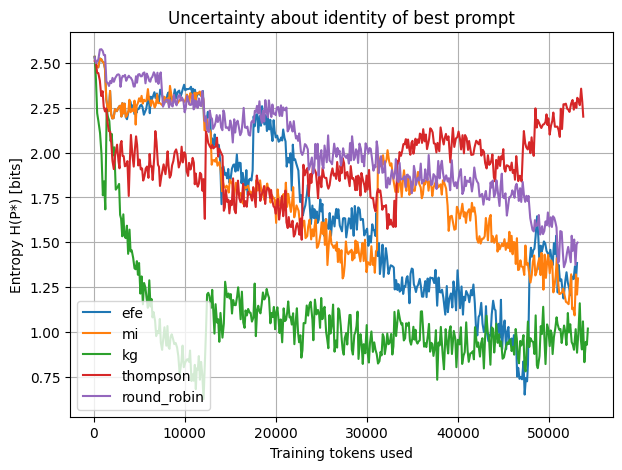

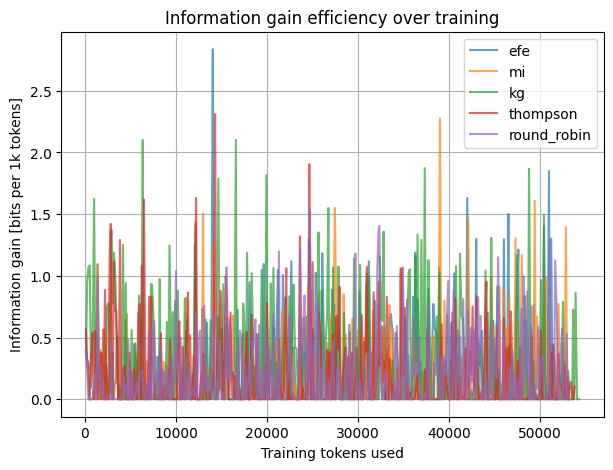

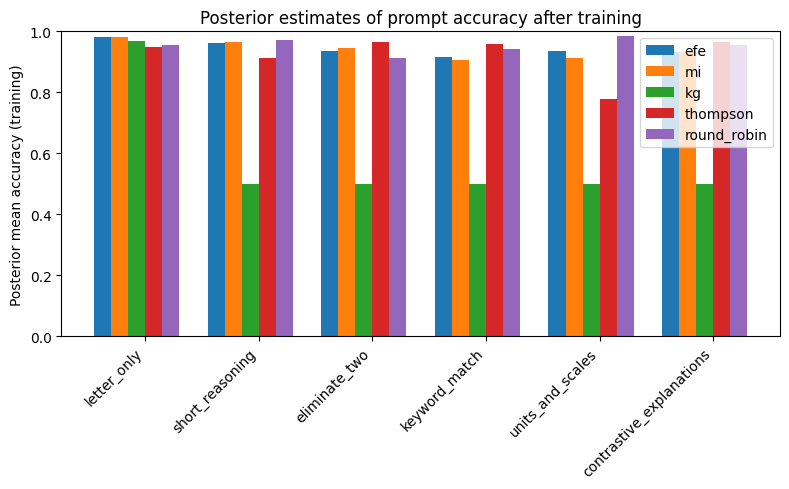

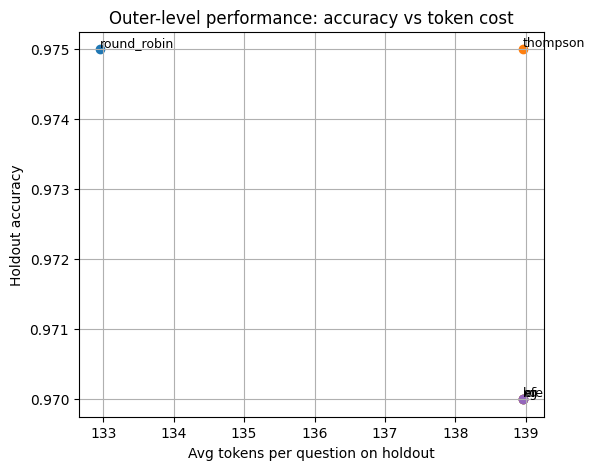

,policy,best_prompt,train_tokens,holdout_accuracy,holdout_ci_low,holdout_ci_high,holdout_avg_tokens,holdout_n,post_mean_train,post_ci_low_train,post_ci_high_train
0,round_robin,units_and_scales,53134,0.975,0.953362,0.996638,132.955,200,0.985294,0.956891,1.000000
1,thompson,contrastive_explanations,53758,0.975,0.953362,0.996638,138.955,200,0.964706,0.925707,1.000000
2,efe,letter_only,53074,0.970,0.946358,0.993642,138.955,200,0.982759,0.959172,1.000000
3,kg,letter_only,54265,0.970,0.946358,0.993642,138.955,200,0.967662,0.950390,0.984933
4,mi,letter_only,53181,0.970,0.946358,0.993642,138.955,200,0.982906,0.959518,1.000000


In [ ]:
#@title Plot training dynamics and posterior prompt accuracies

# Flatten per-step logs into a single DataFrame
log_rows = []
for res in all_results:
    for row in res["log"]:
        log_rows.append(row)
log_df = pd.DataFrame(log_rows)

# Entropy of P* over training
plt.figure(figsize=(7, 5))
for pol in POLICIES:
    df = log_df[log_df["policy"] == pol]
    if len(df) == 0:
        continue
    plt.plot(df["cum_tokens"], df["H_after"], label=pol)
plt.xlabel("Training tokens used")
plt.ylabel("Entropy H(P*) [bits]")
plt.title("Uncertainty about identity of best prompt")
plt.legend()
plt.grid(True)
plt.show()

# Instantaneous information efficiency (bits per 1k tokens)
plt.figure(figsize=(7, 5))
for pol in POLICIES:
    df = log_df[log_df["policy"] == pol]
    if len(df) == 0:
        continue
    plt.plot(
        df["cum_tokens"],
        df["IE_bits_per_1k_tokens"],
        label=pol,
        alpha=0.7,
    )
plt.xlabel("Training tokens used")
plt.ylabel("Information gain [bits per 1k tokens]")
plt.title("Information gain efficiency over training")
plt.legend()
plt.grid(True)
plt.show()

# Posterior mean accuracies per prompt after training, per policy
indices = np.arange(len(VARIANTS))
width = 0.15

plt.figure(figsize=(8, 5))
for j, res in enumerate(all_results):
    means = posterior_means(res["betas"])
    offsets = indices + (j - len(all_results) / 2) * width
    plt.bar(offsets, means, width=width, label=res["policy"])
plt.xticks(indices, [v.name for v in VARIANTS], rotation=45, ha="right")
plt.ylim(0, 1.0)
plt.ylabel("Posterior mean accuracy (training)")
plt.title("Posterior estimates of prompt accuracy after training")
plt.legend()
plt.tight_layout()
plt.show()

# Holdout accuracy vs average tokens per question
plt.figure(figsize=(6, 5))
for _, row in summary_df.iterrows():
    plt.scatter(row["holdout_avg_tokens"], row["holdout_accuracy"], label=row["policy"])
    plt.text(
        row["holdout_avg_tokens"],
        row["holdout_accuracy"],
        row["policy"],
        fontsize=9,
        ha="left",
        va="bottom",
    )
plt.xlabel("Avg tokens per question on holdout")
plt.ylabel("Holdout accuracy")
plt.title("Outer-level performance: accuracy vs token cost")
plt.grid(True)
plt.show()

summary_df